In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# Question (1) (a) (b)

In [2]:
full_dataset = tf.keras.preprocessing.image_dataset_from_directory('../data/images',
                                                                   label_mode='categorical',
                                                                   batch_size=5)

Found 1236 files belonging to 21 classes.


In [3]:
full_dataset_size = len(list(full_dataset))
train_dataset_size = int(0.7 * full_dataset_size)
validate_dataset_size = int(0.15 * full_dataset_size)

train_dataset = full_dataset.take(train_dataset_size)
remaining = full_dataset.skip(train_dataset_size)  
validate_dataset = remaining.take(validate_dataset_size)
test_dataset = remaining.skip(validate_dataset_size)

2022-12-04 22:45:58.545761: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validate_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 173
Number of validation batches: 37
Number of test batches: 38


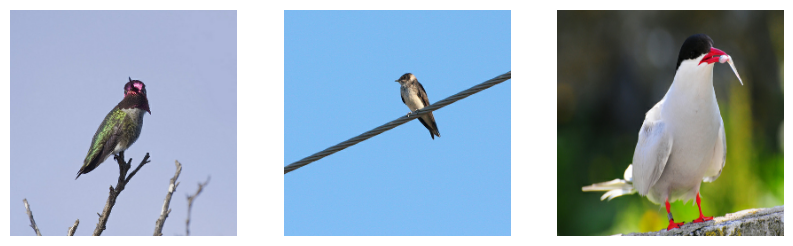

In [5]:
# class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validate_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Question (1) (c)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(height=256, width=256),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2)),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

2022-12-04 22:46:00.763922: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191
2022-12-04 22:46:02.402230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191
2022-12-04 22:46:03.937039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


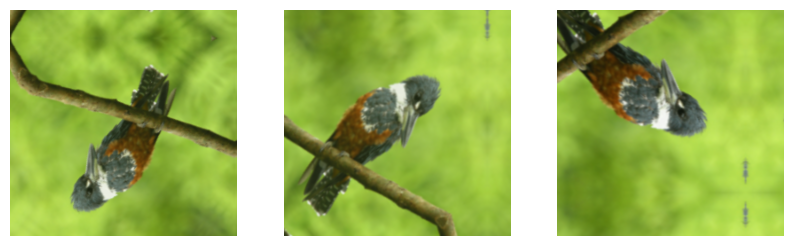

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 8, 8, 1280)


In [11]:
base_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(21, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 21)


In [14]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(name='EfficientNetB0', inputs=inputs, outputs=outputs)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [16]:
model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1280)              1639680   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                    

In [17]:
len(model.trainable_variables)

4

In [18]:
loss0, accuracy0, precision0, recall0 = model.evaluate(validate_dataset)

37/37 [==============================] - 5s 96ms/step - loss: 3.0832 - accuracy: 0.0270 - precision: 0.0000e+00 - recall: 0.0000e+00


In [19]:
print("Initial Loss: {:.2f}".format(loss0))
print("Initial Accuracy: {:.2f}".format(accuracy0))
print("Initial Precision: {:.2f}".format(precision0))
print("Initial Recall: {:.2f}".format(recall0))

Initial Loss: 3.08
Initial Accuracy: 0.03
Initial Precision: 0.00
Initial Recall: 0.00


In [20]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validate_dataset)

Epoch 1/50


2022-12-04 22:46:17.335440: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: EfficientNetB0/sequential/random_crop/loop_body/cond/branch_executed/_9


173/173 [==============================] - 26s 118ms/step - loss: 1.5121 - accuracy: 0.5491 - precision: 0.7398 - recall: 0.4173 - val_loss: 0.8028 - val_accuracy: 0.7676 - val_precision: 0.8489 - val_recall: 0.6378
Epoch 2/50
173/173 [==============================] - 20s 115ms/step - loss: 0.6393 - accuracy: 0.7896 - precision: 0.8513 - recall: 0.7410 - val_loss: 0.6404 - val_accuracy: 0.8000 - val_precision: 0.8250 - val_recall: 0.7135
Epoch 3/50
173/173 [==============================] - 19s 110ms/step - loss: 0.4542 - accuracy: 0.8555 - precision: 0.8995 - recall: 0.8173 - val_loss: 0.5742 - val_accuracy: 0.7838 - val_precision: 0.8598 - val_recall: 0.7622
Epoch 4/50
173/173 [==============================] - 19s 110ms/step - loss: 0.3378 - accuracy: 0.8809 - precision: 0.9141 - recall: 0.8613 - val_loss: 0.6589 - val_accuracy: 0.7784 - val_precision: 0.8519 - val_recall: 0.7459
Epoch 5/50
173/173 [==============================] - 20s 113ms/step - loss: 0.2938 - accuracy: 0.8971 

173/173 [==============================] - 20s 114ms/step - loss: 0.1545 - accuracy: 0.9699 - precision: 0.9710 - recall: 0.9676 - val_loss: 1.4946 - val_accuracy: 0.7784 - val_precision: 0.7802 - val_recall: 0.7676
Epoch 38/50
173/173 [==============================] - 18s 106ms/step - loss: 0.0922 - accuracy: 0.9746 - precision: 0.9745 - recall: 0.9723 - val_loss: 1.3962 - val_accuracy: 0.8054 - val_precision: 0.8087 - val_recall: 0.8000
Epoch 39/50
173/173 [==============================] - 18s 104ms/step - loss: 0.1079 - accuracy: 0.9688 - precision: 0.9699 - recall: 0.9688 - val_loss: 1.1716 - val_accuracy: 0.8324 - val_precision: 0.8324 - val_recall: 0.8324
Epoch 40/50
173/173 [==============================] - 18s 103ms/step - loss: 0.1077 - accuracy: 0.9676 - precision: 0.9687 - recall: 0.9665 - val_loss: 1.2472 - val_accuracy: 0.8486 - val_precision: 0.8579 - val_recall: 0.8486
Epoch 41/50
173/173 [==============================] - 18s 106ms/step - loss: 0.0810 - accuracy: 0.9

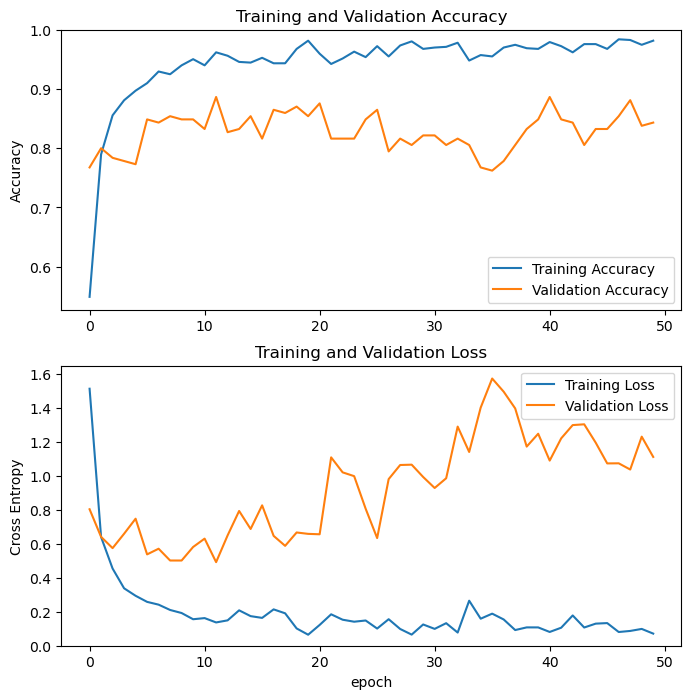

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
loss, accuracy, prediction, recall = model.evaluate(test_dataset)
print('Test Accuracy:', accuracy)

38/38 [==============================] - 3s 67ms/step - loss: 1.3706 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495
Test Accuracy: 0.8494623899459839
